[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/033_receta_entrenamiento/receta_entrenamiento.ipynb)

#LABORATORIO 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1. CONFIGURAR LAS TRANSFORMACIONES Y CARGAR EL DATASET

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np

# Ruta al dataset en Google Drive
data_dir = '/content/drive/MyDrive/SIS 421/LAB2/dataset_plantas'

# Transformaciones: convertir a tensor (sin normalización)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Cargar el dataset con las transformaciones
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Dividir en conjunto de entrenamiento (80%) y conjunto de prueba (20%)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
trainset, testset = random_split(full_dataset, [train_size, test_size])

# Crear DataLoaders
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

# Clases
classes = full_dataset.classes
print(classes)

['laurel', 'limon', 'membrillo', 'olivo', 'papaya']


##2. VISUALIZACIÓN DE LAS IMÁGENES

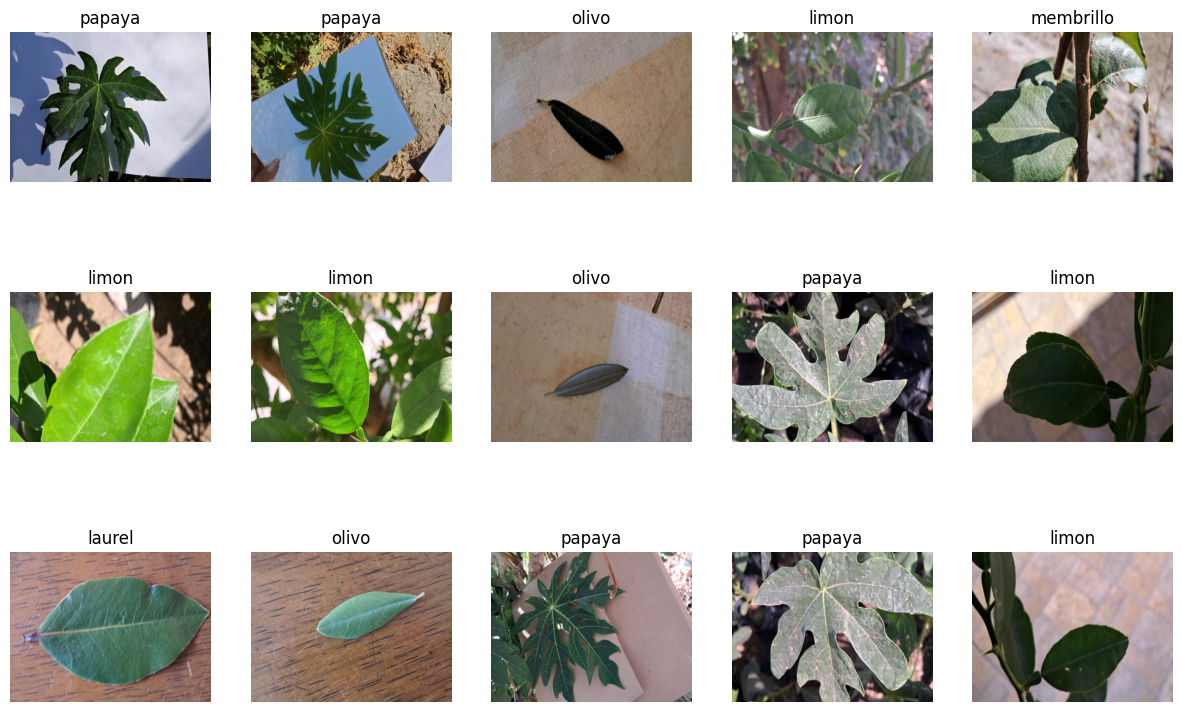

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img.numpy()  # Convertir a numpy array
    img = np.transpose(img, (1, 2, 0))  # Cambiar el formato a (H, W, C)
    plt.imshow(img)
    plt.axis('off')

r, c = 3, 5
plt.figure(figsize=(c * 3, r * 3))

for row in range(r):
    for col in range(c):
        index = c * row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset) - 1)
        img, label = trainset[ix]

        # Visualizar imagen
        imshow(img)
        plt.title(classes[label])

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


##3. CONVERTIR IMÁGENES A ARRAYS DE NUMPY

In [ ]:
# Función para convertir imágenes de tensor a numpy array
"""
def to_numpy(img):
    img = img.numpy()  # Convertir a numpy array
    img = np.transpose(img, (1, 2, 0))  # Cambiar el formato a (H, W, C)
    return img

# Función para convertir DataLoader a arrays de numpy
def save_data_loader_to_numpy(data_loader, file_prefix):
    all_images = []
    all_labels = []

    for i, (images, labels) in enumerate(data_loader):
        images_np = np.array([to_numpy(img) for img in images])
        labels_np = np.array(labels.numpy())

        all_images.append(images_np)
        all_labels.append(labels_np)

        # Guardar cada lote en un archivo si es necesario
        np.savez(f'{file_prefix}_images_batch_{i}.npz', images=images_np)
        np.savez(f'{file_prefix}_labels_batch_{i}.npz', labels=labels_np)

    # Concatenar todos los lotes y guardar
    all_images_np = np.concatenate(all_images, axis=0)
    all_labels_np = np.concatenate(all_labels, axis=0)

    np.savez(f'{file_prefix}_images.npz', images=all_images_np)
    np.savez(f'{file_prefix}_labels.npz', labels=all_labels_np)

    return all_images_np, all_labels_np

# Guardar imágenes y etiquetas del conjunto de entrenamiento y prueba
train_images, train_labels = save_data_loader_to_numpy(trainloader, 'train')
test_images, test_labels = save_data_loader_to_numpy(testloader, 'test')

# Mostrar las dimensiones de los arrays resultantes
print("Dimensiones de train_images:", train_images.shape)
print("Dimensiones de train_labels:", train_labels.shape)
print("Dimensiones de test_images:", test_images.shape)
print("Dimensiones de test_labels:", test_labels.shape)
"""

'\ndef to_numpy(img):\n    img = img.numpy()  # Convertir a numpy array\n    img = np.transpose(img, (1, 2, 0))  # Cambiar el formato a (H, W, C)\n    return img\n\n# Función para convertir DataLoader a arrays de numpy\ndef save_data_loader_to_numpy(data_loader, file_prefix):\n    all_images = []\n    all_labels = []\n\n    for i, (images, labels) in enumerate(data_loader):\n        images_np = np.array([to_numpy(img) for img in images])\n        labels_np = np.array(labels.numpy())\n\n        all_images.append(images_np)\n        all_labels.append(labels_np)\n\n        # Guardar cada lote en un archivo si es necesario\n        np.savez(f\'{file_prefix}_images_batch_{i}.npz\', images=images_np)\n        np.savez(f\'{file_prefix}_labels_batch_{i}.npz\', labels=labels_np)\n\n    # Concatenar todos los lotes y guardar\n    all_images_np = np.concatenate(all_images, axis=0)\n    all_labels_np = np.concatenate(all_labels, axis=0)\n\n    np.savez(f\'{file_prefix}_images.npz\', images=all_ima

##4. COMPROBACIÓN DE TIPOS DE DATOS DESDE EL DATALOADER
Si no estás utilizando el código para convertir imágenes a arrays de numpy, no necesitas ejecutar la comprobación de tipo de datos en train_images y train_labels en este momento, ya que esos arrays no se han creado.

Dado que estás trabajando con los DataLoaders, y quieres verificar el tipo de datos que se obtiene de ellos, te muestro cómo podrías comprobar el tipo de datos directamente desde el DataLoader sin necesidad de convertir todo el conjunto a numpy arrays.

In [ ]:
# Comprobar el tipo de datos de las imágenes y etiquetas de un lote del DataLoader
import torch

# Tomar un lote de datos del DataLoader
for images, labels in trainloader:
    print("Tipo de datos de imágenes:", images.dtype)
    print("Tipo de datos de etiquetas:", labels.dtype)
    break  # Solo necesitamos revisar el tipo de un lote

Tipo de datos de imágenes: torch.float32
Tipo de datos de etiquetas: torch.int64


##5. OBTENCIÓN DE ESTADISTICAS A PARTIR DE TENSORES DE PYTORCH
Para obtener estadísticas como los valores máximos y mínimos de las imágenes, puedes hacerlo directamente desde los tensores de PyTorch en lugar de convertir a numpy arrays, lo cual es más eficiente en términos de memoria.

In [ ]:
"""
import torch

# Variables para acumular valores
max_value = -float('inf')
min_value = float('inf')

# Iterar sobre el DataLoader para encontrar los valores máximos y mínimos
for images, _ in trainloader:
    # Encuentra el máximo y mínimo en el lote actual
    batch_max = images.max()
    batch_min = images.min()

    # Actualizar los valores máximos y mínimos globales
    if batch_max > max_value:
        max_value = batch_max
    if batch_min < min_value:
        min_value = batch_min

print("Valor máximo:", max_value.item())
print("Valor mínimo:", min_value.item())

"""

'\nimport torch\n\n# Variables para acumular valores\nmax_value = -float(\'inf\')\nmin_value = float(\'inf\')\n\n# Iterar sobre el DataLoader para encontrar los valores máximos y mínimos\nfor images, _ in trainloader:\n    # Encuentra el máximo y mínimo en el lote actual\n    batch_max = images.max()\n    batch_min = images.min()\n\n    # Actualizar los valores máximos y mínimos globales\n    if batch_max > max_value:\n        max_value = batch_max\n    if batch_min < min_value:\n        min_value = batch_min\n\nprint("Valor máximo:", max_value.item())\nprint("Valor mínimo:", min_value.item())\n\n'

##6. NORMALIZACIÓN DE IMÁGENES. CÁLCULO DE MEDIA Y DESVIACIÓN ESTÁNDAR

In [ ]:
import torch

# Variables para acumular valores
mean = torch.zeros(3)
std = torch.zeros(3)

# Iterar sobre el DataLoader para calcular la media y desviación estándar
for images, _ in trainloader:
    # Normalizar las imágenes a [0, 1]
    images = images / 255.0

    # Calcular la media y desviación estándar en el lote
    mean += images.mean(dim=[0, 2, 3])
    std += images.std(dim=[0, 2, 3])

# Dividir por el número total de lotes para obtener la media y desviación estándar promedio
mean /= len(trainloader)
std /= len(trainloader)

print("Media:", mean)
print("Desviación estándar:", std)


Media: tensor([0.0019, 0.0019, 0.0017])
Desviación estándar: tensor([0.0009, 0.0008, 0.0010])


##7. DISTRIBUCIÓN DE CLASES

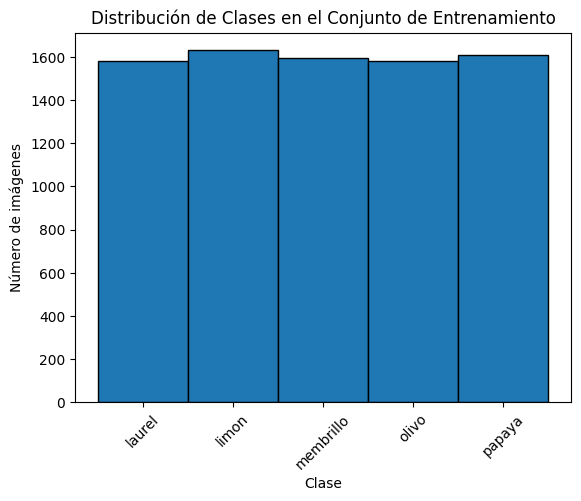

In [ ]:
import matplotlib.pyplot as plt

# Obtener las etiquetas de entrenamiento del DataLoader
train_labels_all = np.array([label for _, label in trainloader.dataset])

# Crear un histograma para la distribución de clases
plt.hist(train_labels_all, bins=len(classes), range=(-0.5, len(classes) - 0.5), edgecolor='black')
plt.xticks(range(len(classes)), classes, rotation=45)  # Etiquetas de clase en el eje x
plt.xlabel('Clase')
plt.ylabel('Número de imágenes')
plt.title('Distribución de Clases en el Conjunto de Entrenamiento')
plt.show()


##8. NÚMERO DE MUESTRAS POR CADA CLASE

In [ ]:
import numpy as np

# Obtener las etiquetas de entrenamiento del DataLoader
train_labels_all = np.array([label for _, label in trainloader.dataset])

# Contar la frecuencia de cada clase
unique, counts = np.unique(train_labels_all, return_counts=True)

# Mostrar las clases únicas y sus respectivos conteos
for cls, count in zip(unique, counts):
    print(f'Clase: {classes[cls]}, Cantidad: {count}')


Clase: laurel, Cantidad: 1582
Clase: limon, Cantidad: 1632
Clase: membrillo, Cantidad: 1594
Clase: olivo, Cantidad: 1584
Clase: papaya, Cantidad: 1608


División Aleatoria: Cuando divides el dataset en conjuntos de entrenamiento y prueba, la división se hace aleatoriamente. Aunque el código asegura que el conjunto de entrenamiento es el 80% del total, la división puede resultar en una ligera variación en la cantidad de imágenes por clase debido a la aleatoriedad del muestreo.\
Para verificar esto, puedes calcular el número total de imágenes en el dataset original y verificar el 80%:

In [ ]:
# Número total de imágenes en el dataset original
total_images = len(full_dataset)
expected_train_size = int(0.8 * total_images)

print(f'Número total de imágenes: {total_images}')
print(f'Número esperado de imágenes en entrenamiento (80%): {expected_train_size}')


Número total de imágenes: 10000
Número esperado de imágenes en entrenamiento (80%): 8000


##8. DEFINICIÓN MODELO MLP

In [ ]:
import torch
import torch.nn as nn

def build_model(D_in=3*600*800, H=50, D_out=5):
    """
    Crea un modelo de Perceptrón Multicapa (MLP) con una sola capa oculta.

    Args:
    - D_in (int): Número de características de entrada (tamaño de la imagen aplanada).
    - H (int): Número de unidades en la capa oculta (debe ser al menos 50).
    - D_out (int): Número de clases de salida.

    Returns:
    - model (nn.Module): Modelo MLP.
    """
    model = nn.Sequential(
        nn.Linear(D_in, H),
        nn.ReLU(),
        nn.Linear(H, D_out)
    )

    # Verificar si CUDA está disponible y mover el modelo a la GPU si es posible
    if torch.cuda.is_available():
        model = model.cuda()

    return model



###ENSAYO DEL MODELO CON DATOS ALEATORIOS
Para verificar que la definición de nuestra red neuronal no tiene errores.

In [ ]:
# Crear el modelo
model = build_model()

# Crear una entrada aleatoria con el tamaño adecuado
test_input = torch.randn((16, 3*800*600))  # Tamaño del batch: 64, Tamaño de la imagen: 3*800*600

# Mover la entrada a GPU si está disponible
if torch.cuda.is_available():
    test_input = test_input.cuda()

# Pasar la entrada a través del modelo
test_output = model(test_input)

# Mostrar el tamaño de la salida
print(test_output.shape)

torch.Size([16, 5])


##FIT DE UNA SOLA MUESTRA (EJEMPLO)

In [ ]:
"""
import torch

# No es necesario convertir las imágenes y etiquetas a arrays de NumPy, los mantenemos como tensores
# Dividir los datos: 80% para entrenamiento y 20% para validación
X_train, X_val = torch.stack([img for img, label in trainset[:6400]]), torch.stack([img for img, label in trainset[6400:]])
y_train, y_val = torch.tensor([label for img, label in trainset[:6400]]), torch.tensor([label for img, label in trainset[6400:]])

# Crear el subconjunto de 1000 ejemplos a partir del conjunto de entrenamiento
X_subset = torch.stack([img for img, label in trainset[:1000]])
y_subset = torch.tensor([label for img, label in trainset[:1000]])

# Comprobar las dimensiones de los tensores
X_train.shape, X_val.shape, X_subset.shape

"""

'\nimport torch\n\n# No es necesario convertir las imágenes y etiquetas a arrays de NumPy, los mantenemos como tensores\n# Dividir los datos: 80% para entrenamiento y 20% para validación\nX_train, X_val = torch.stack([img for img, label in trainset[:6400]]), torch.stack([img for img, label in trainset[6400:]])\ny_train, y_val = torch.tensor([label for img, label in trainset[:6400]]), torch.tensor([label for img, label in trainset[6400:]])\n\n# Crear el subconjunto de 1000 ejemplos a partir del conjunto de entrenamiento\nX_subset = torch.stack([img for img, label in trainset[:1000]])\ny_subset = torch.tensor([label for img, label in trainset[:1000]])\n\n# Comprobar las dimensiones de los tensores\nX_train.shape, X_val.shape, X_subset.shape\n\n'

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Definir el dispositivo (GPU si disponible, sino CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Actualizar la función build_model para el nuevo tamaño de entrada
def build_model(D_in=600*800*3, H=50, D_out=5):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).to(device)  # Mover a la GPU si disponible

# Adaptar el Dataset para usar un solo ejemplo
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Extraer un solo ejemplo del dataset de entrenamiento
example_image, example_label = trainset[0]  # Obtener el primer ejemplo del dataset

# Convertir el ejemplo a tensores y crear un DataLoader
example_image = example_image.view(1, -1)  # Aplana la imagen a un vector
example_label = torch.tensor([example_label])

dataset = CustomDataset(example_image, example_label)
dataloader = DataLoader(dataset, batch_size=1)

# Definir el modelo, criterio y optimizador
epochs = 5
criterion = torch.nn.CrossEntropyLoss()
model = build_model().to(device)  # Mover el modelo al dispositivo
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Entrenamiento del modelo
for e in range(1, epochs + 1):
    for x_b, y_b in dataloader:
        x_b, y_b = x_b.to(device), y_b.to(device)  # Mover los datos al dispositivo
        y_pred = model(x_b)
        loss = criterion(y_pred, y_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch {e}/{epochs} - Loss: {loss.item():.5f} - y: {y_b.item()} - y_pred: {torch.argmax(y_pred, dim=1).item()}")


Epoch 1/5 - Loss: 1.75839 - y: 2 - y_pred: 1
Epoch 2/5 - Loss: 0.00000 - y: 2 - y_pred: 2
Epoch 3/5 - Loss: 0.00000 - y: 2 - y_pred: 2
Epoch 4/5 - Loss: 0.00000 - y: 2 - y_pred: 2
Epoch 5/5 - Loss: 0.00000 - y: 2 - y_pred: 2


OBSERVACIÓN:\
Epoch 1/5 - Loss: 1.58698 - y: 3 - y_pred: 1:

Loss: La pérdida es alta en la primera época, lo que es esperado en el inicio del entrenamiento.
y: 3: La etiqueta verdadera para el ejemplo es 3 (posiblemente representa una de las clases de tu dataset, como olivo, por ejemplo).
y_pred: 1: El modelo predijo la clase 1, que es incorrecta.
Epoch 2/5 - Loss: 0.00000 - y: 3 - y_pred: 3:

Loss: La pérdida es ahora 0. El modelo ha aprendido perfectamente a predecir este ejemplo.
y_pred: 3: El modelo ha predicho correctamente la clase 3, que coincide con la etiqueta verdadera (y).
Epoch 3/5 al Epoch 5/5:

El modelo continúa prediciendo correctamente la clase 3 para el ejemplo de entrenamiento, y la pérdida permanece en 0.

##FIT DE UN SOLO BATCH

In [ ]:
import torch

# Definir el dispositivo (GPU si disponible, sino CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Actualizar la función build_model para el nuevo tamaño de entrada
def build_model(D_in=600*800*3, H=50, D_out=5):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).to(device)  # Mover a la GPU si disponible

# Extraer un solo batch del train_loader
data_iter = iter(trainloader)
images, labels = next(data_iter)

# Aplanar las imágenes y moverlas al dispositivo adecuado
images = images.view(images.size(0), -1).to(device)  # Aplanar imágenes
labels = labels.to(device)  # Mover etiquetas al dispositivo

# Crear el modelo y configurar el entrenamiento
model = build_model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Imprimir si se está usando GPU o CPU
print(f"Trabajando con {'GPU' if device.type == 'cuda' else 'CPU'}")

# Entrenamiento del modelo en un solo batch
epochs = 200
model.train()  # Configura el modelo para entrenamiento

for e in range(1, epochs + 1):
    # Forward pass
    y_pred = model(images)

    # Calcular la pérdida
    loss = criterion(y_pred, labels)

    # Backward pass y optimización
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Imprimir resultados cada 10 épocas
    if e % 10 == 0:
        print(f"Epoch {e}/{epochs} - Loss: {loss.item():.5f} - y: {labels.cpu().numpy()} - y_pred: {torch.argmax(y_pred, axis=1).cpu().numpy()}")



Trabajando con CPU
Epoch 10/200 - Loss: 319.31229 - y: [1 2 0 2 1 0 3 4 1 1 4 4 4 0 0 0] - y_pred: [1 0 0 0 1 0 0 4 1 1 0 0 0 0 0 0]
Epoch 20/200 - Loss: 12.19323 - y: [1 2 0 2 1 0 3 4 1 1 4 4 4 0 0 0] - y_pred: [1 2 1 2 1 1 3 4 1 1 4 4 4 1 1 1]
Epoch 30/200 - Loss: 2.76984 - y: [1 2 0 2 1 0 3 4 1 1 4 4 4 0 0 0] - y_pred: [0 0 0 0 0 0 0 0 4 1 0 0 0 0 0 0]
Epoch 40/200 - Loss: 1.29944 - y: [1 2 0 2 1 0 3 4 1 1 4 4 4 0 0 0] - y_pred: [2 2 0 2 0 0 0 0 4 1 0 0 0 0 0 0]
Epoch 50/200 - Loss: 1.32272 - y: [1 2 0 2 1 0 3 4 1 1 4 4 4 0 0 0] - y_pred: [1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
Epoch 60/200 - Loss: 1.24402 - y: [1 2 0 2 1 0 3 4 1 1 4 4 4 0 0 0] - y_pred: [1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0]
Epoch 70/200 - Loss: 1.23120 - y: [1 2 0 2 1 0 3 4 1 1 4 4 4 0 0 0] - y_pred: [1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0]
Epoch 80/200 - Loss: 1.11402 - y: [1 2 0 2 1 0 3 4 1 1 4 4 4 0 0 0] - y_pred: [1 0 0 2 0 0 0 0 1 1 0 0 1 0 0 0]
Epoch 90/200 - Loss: 0.93828 - y: [1 2 0 2 1 0 3 4 1 1 4 4 4 0 0 0] - y_pred: [1 0

##ENTRENANDO CON UN SUBCONJUNTO DE DATOS

####Definir un subconjunto-> subset_trainloader que sea representativo de nuestros datos de entrenamiento trainset. Definir val_loader a partir de testset.

In [ ]:
from torch.utils.data import DataLoader, Subset
import numpy as np

# Definir el tamaño del subconjunto
subset_size = 200  # Tamaño del subconjunto (puedes ajustar según sea necesario)

# Seleccionar índices aleatorios para el subconjunto
indices = list(range(len(trainset)))
np.random.shuffle(indices)
subset_indices = indices[:subset_size]

# Crear subconjunto del dataset de entrenamiento
subset_trainset = Subset(trainset, subset_indices)

# Crear DataLoader para el subconjunto de entrenamiento
subset_trainloader = DataLoader(subset_trainset, batch_size=16, shuffle=True)

# Crear DataLoader para el conjunto de prueba
val_loader = DataLoader(testset, batch_size=50, shuffle=False)     #batch_size=1000 en receta_entrenamiento


####Definición del modelo y la funcion fit() -> Mecanismo de entrenamiento. Guardar el modelo en ckpt.pt

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score

# Definir el dispositivo GPU o CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1, keepdims=True)

def build_model():
    # Define tu modelo MLP aquí, e.g.,
    return torch.nn.Sequential(
        torch.nn.Linear(600 * 800 * 3, 128),  # Asumiendo imágenes RGB redimensionadas a 600x800
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 5)  # Asegúrate de definir num_classes
    )


def fit(model, dataloader, optimizer, scheduler=None, epochs=10, log_each=1, weight_decay=0, early_stopping=0, verbose=1):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0

    # Mover el modelo al dispositivo
    model.to(device)

    # Imprimir dispositivo del modelo solo una vez
    print(f"Dispositivo del modelo: {next(model.parameters()).device}")

    for e in range(1, epochs + 1):
        _l, _acc = [], []
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])

        model.train()
        for x_b, y_b in dataloader['train']:
             # Aplanar las imágenes y mover las etiquetas y los datos al dispositivo
            x_b = x_b.view(x_b.size(0), -1).to(device)
            y_b = y_b.to(device)

            # Imprimir dispositivo de los datos cada log_each épocas
            # if not e % log_each and verbose:
            #     print(f"Dispositivo de los datos: {x_b.device}, {y_b.device}")

            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))

        l.append(np.mean(_l))
        acc.append(np.mean(_acc))

        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
               # Aplanar las imágenes y mover las etiquetas y los datos al dispositivo
                x_b = x_b.view(x_b.size(0), -1).to(device)
                y_b = y_b.to(device)

                # Imprimir dispositivo de los datos en validación cada log_each épocas
                # if not e % log_each and verbose:
                #     print(f"Dispositivo de los datos en validación: {x_b.device}, {y_b.device}")

                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))

        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))

        # Guardar el mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            if verbose == 2:
                print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")

        step += 1
        if scheduler:
            scheduler.step()

        # Early stopping
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break

        if not e % log_each and verbose:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")

    # Cargar el mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l) + 1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}


####Configuración de diferentes learning rate para elegir el adecuado

In [ ]:
lrs = [0.0005, 0.0002, 0.0001]
hists = []
for lr in lrs:
    print(f"Probando lr {lr}")
    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)  # Aplicar weight_decay para L2 Regularization
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR cada 5 epochs
    hist = fit(model, {'train': subset_trainloader, 'val': val_loader}, optimizer, scheduler=scheduler, epochs=10, verbose=0)
    hists.append(hist)


Probando lr 0.0005
Dispositivo del modelo: cpu
Probando lr 0.0002
Dispositivo del modelo: cpu
Probando lr 0.0001
Dispositivo del modelo: cpu


In [ ]:
"""
from google.colab import files
files.download('/content/ckpt.pt')

"""

####Gráficos del entrenamiento para diferentes learning rate

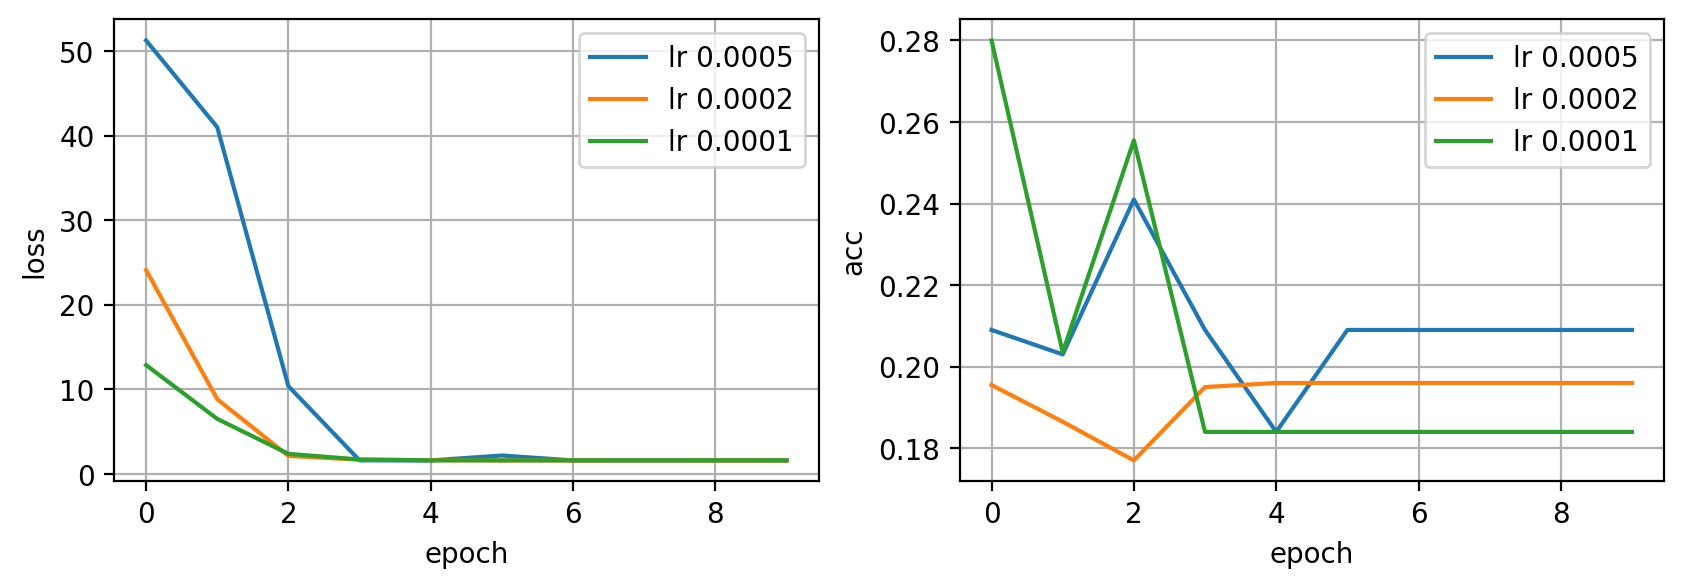

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
for i in range(len(lrs)):
    ax.plot(hists[i]['loss'], label=f'lr {lrs[i]}')
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
for i in range(len(lrs)):
    ax.plot(hists[i]['val_acc'], label=f'lr {lrs[i]}')
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

###9. Evaluacion del modelo mediante el calculo de la precision para el conjunto de validacion

In [ ]:
import torch
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Subset
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define el modelo usando torch.nn.Sequential
model = torch.nn.Sequential(
    torch.nn.Linear(600 * 800 * 3, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 5)
)

# Mover el modelo al dispositivo
model.to(device)

# Cargar el estado del modelo guardado
model.load_state_dict(torch.load('ckpt.pt'))

model.eval()  # Poner en modo de evaluación

# Evaluar el modelo en el DataLoader de validación
def evaluate_model(model, dataloader):
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
             # Aplanar las imágenes antes de pasarlas al modelo
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)

            #Pasar las imagenes a traves del  modelo
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            #Almacenar las etiquetas y predicciones
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    #Calcular la precision
    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy

# Evaluar el modelo en el conjunto de validacion
test_accuracy = evaluate_model(model, val_loader)
print(f"Precision: {test_accuracy:.4f}")


Precision: 0.2800


###10. Exportar el  modelo con Torchscript

In [ ]:
import torch

# Definicion del Modelo
model = torch.nn.Sequential(
    torch.nn.Linear(600 * 800 * 3, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 5)
)

# Cargar el estado del modelo guardado
model.load_state_dict(torch.load('ckpt.pt'))

model.eval()  # Poner el modelo en modo evaluación

# Definir un tensor de entrada ficticio
input_tensor = torch.randn(1, 600 * 800 * 3)  # Ajustar las dimensiones

# Convertir el modelo a TorchScript usando tracing
scripted_model = torch.jit.trace(model, input_tensor)

scripted_model.save('model_tracing.pt')


Observacion: input_tensor simula una entrada real al modelo. El tensor tiene una dimensión de 1 x 600 * 800 * 3, que corresponde al tamaño de una imagen aplanada y una batch size de 1.

###10. Exportar el modelo con ONNX

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 36.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.onnx

# Define el modelo usando torch.nn.Sequential
model = torch.nn.Sequential(
    torch.nn.Linear(600 * 800 * 3, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 5)
)

# Cargar el estado del modelo guardado
model.load_state_dict(torch.load('ckpt.pt'))
model.eval()  #Poner en modo de evaluación

# Definir un tensor de entrada ficticio
input_tensor = torch.randn(1, 600 * 800 * 3)

# Exportar el modelo a ONNX
torch.onnx.export(
    model,  # El modelo que deseas exportar
    input_tensor,  # Tensor de entrada ficticio para el modelo
    'model.onnx',  # Nombre del archivo
    input_names=['input'],  # Nombre del tensor de entrada (opcional)
    output_names=['output'],  # Nombre del tensor de salida (opcional)
    export_params=True,  # Exportar los parámetros del modelo
    verbose=False,  # Detalles del proceso de exportación
    opset_version=11  # Versión del conjunto de operaciones ONNX
)


In [ ]:
from google.colab import files
files.download('/content/model.onnx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>